In [10]:
import os
import sys
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
print(f"base_path: {base_path}")
sys.path.append(base_path)

base_path: /home/toc3/sr-press


In [11]:
from functools import partial
from xgboost import XGBClassifier
from gplearn.genetic import SymbolicClassifier
import matplotlib.pyplot as plt

In [12]:
from express.databases import SQLiteDatabase
from express.datasets import PressingDataset
from express.components import press
from express.components.utils import log_model, load_model
from express.visualization import plot_action
from express.utils import add_names

In [13]:
TRAIN_DB_PATH = os.path.join(base_path, "stores/train_database.sqlite")
TEST_DB_PATH = os.path.join(base_path, "stores/test_database.sqlite")

train_db = SQLiteDatabase(TRAIN_DB_PATH)
test_db = SQLiteDatabase(TEST_DB_PATH)

print("train_db:", train_db)
print("test_db:", test_db)

train_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f5a75398550>
test_db: <express.databases.sqlite.SQLiteDatabase object at 0x7f5a753987c0>


In [14]:
dataset_train = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "train"))
dataset_test = partial(PressingDataset, path=os.path.join(base_path, "stores", "datasets", "test"))

print("dataset_train:", dataset_train)
print("dataset_test:", dataset_test)

dataset_train: functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/sr-press/stores/datasets/train')
dataset_test: functools.partial(<class 'express.datasets.PressingDataset'>, path='/home/toc3/sr-press/stores/datasets/test')


In [15]:
from express import features as fs
from express import labels as ls

all_features = [f.__name__ for f in fs.all_features]
all_labels = [f.__name__ for f in ls.all_labels]
print("Features:", all_features)
print("Labels:", all_labels)

Features: ['actiontype', 'actiontype_onehot', 'result', 'result_onehot', 'bodypart', 'bodypart_onehot', 'time', 'startlocation', 'relative_startlocation', 'endlocation', 'relative_endlocation', 'startpolar', 'endpolar', 'movement', 'team', 'time_delta', 'space_delta', 'goalscore', 'angle', 'under_pressure', 'packing_rate', 'ball_height_onehot', 'player_possession_time', 'speed', 'nb_opp_in_path', 'dist_opponent', 'defenders_in_3m_radius', 'closest_3_players']
Labels: ['concede_shots', 'counterpress']


In [16]:
train_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "train"),
    xfns=all_features,#["actiontype"],#["startlocation", "time", "goalscore", "defenders_in_3m_radius", "closest_3_players"], #all_features
    yfns=all_labels,#["counterpress"], #all_labels
    load_cached=True,
    nb_prev_actions=3
)

test_dataset = PressingDataset(
    path= os.path.join(base_path, "stores", "datasets", "test"),
    xfns=["actiontype"],#["startlocation", "time", "goalscore", "defenders_in_3m_radius", "closest_3_players"], #all_features
    yfns=["counterpress"], #all_labels
    load_cached=True,
    nb_prev_actions=3
)

In [17]:
train_dataset.features

type_id_a0  type_id_a1  type_id_a2  type_pass_a0  \
game_id action_id                                                     
3788741 3                  23         0.0        21.0         False   
        19                 23         0.0        21.0         False   
        27                 23         0.0         2.0         False   
        31                 23        21.0        19.0         False   
        35                 23        21.0        21.0         False   
...                       ...         ...         ...           ...   
3943043 2283               23         2.0        22.0         False   
        2286               23         2.0         0.0         False   
        2302               23         4.0        21.0         False   
        2304               23        21.0        23.0         False   
        2309               23        21.0        18.0         False   

                   type_cross_a0  type_throw_in_a0  type_freekick_crossed_a0  \
game_id action_id                                                              
3788741 3                  False             False                     False   
        19                 False             False                     False   
        27                 False             False                     False   
        31                 False             False                     False   
        35                 False             False                     False   
...                          ...               ...                       ...   
3943043 2283               False             False                     False   
        2286               False             False                     False   
        2302               False             False                     False   
        2304               False             False                     False   
        2309               False             False                     False   

                   type_freekick_short_a0  type_corner_crossed_a0  \
game_id action_id                                                   
3788741 3                           False                   False   
        19                          False                   False   
        27                          False                   False   
        31                          False                   False   
        35                          False                   False   
...                                   ...                     ...   
3943043 2283                        False                   False   
        2286                        False                   False   
        2302                        False                   False   
        2304                        False                   False   
        2309                        False                   False   

                   type_corner_short_a0  ...  teammate_3_distance_a2  \
game_id action_id                        ...                           
3788741 3                         False  ...               18.003872   
        19                        False  ...               23.555610   
        27                        False  ...                0.000000   
        31                        False  ...               11.344679   
        35                        False  ...                0.000000   
...                                 ...  ...                     ...   
3943043 2283                      False  ...                0.000000   
        2286                      False  ...               24.903406   
        2302                      False  ...                0.000000   
        2304                      False  ...               13.762356   
        2309                      False  ...               10.550313   

                   opponent_1_x_a2  opponent_1_y_a2  opponent_1_distance_a2  \
game_id action_id                                                             
3788741 3                64.646030        32.493147          

In [18]:
for xfn in train_dataset.xfns.items():
    print(xfn)

(<function actiontype at 0x7f5a770e8550>, ['type_id_a0', 'type_id_a1', 'type_id_a2'])
(<function actiontype_onehot at 0x7f5a770e8670>, ['type_pass_a0', 'type_cross_a0', 'type_throw_in_a0', 'type_freekick_crossed_a0', 'type_freekick_short_a0', 'type_corner_crossed_a0', 'type_corner_short_a0', 'type_take_on_a0', 'type_foul_a0', 'type_tackle_a0', 'type_interception_a0', 'type_shot_a0', 'type_shot_penalty_a0', 'type_shot_freekick_a0', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_keeper_pick_up_a0', 'type_clearance_a0', 'type_bad_touch_a0', 'type_non_action_a0', 'type_dribble_a0', 'type_goalkick_a0', 'type_pressing_a0', 'type_pass_a1', 'type_cross_a1', 'type_throw_in_a1', 'type_freekick_crossed_a1', 'type_freekick_short_a1', 'type_corner_crossed_a1', 'type_corner_short_a1', 'type_take_on_a1', 'type_foul_a1', 'type_tackle_a1', 'type_interception_a1', 'type_shot_a1', 'type_shot_penalty_a1', 'type_shot_freekick_a1', 'type_keeper_save_a1', 'type_keeper_claim_a1',

In [25]:
features = {
    'startlocation': [
        'start_x_a0',
        'start_y_a0',
        'start_x_a1',
        'start_y_a1',
        'start_x_a2',
        'start_y_a2'
    ],
    'endlocation': [
        'end_x_a0',
        'end_y_a0',
        'end_x_a1',
        'end_y_a1',
        'end_x_a2',
        'end_y_a2',
    ],
    'movement': [
        'dx_a0',
        'dy_a0',
        'movement_a0',
        'dx_a1',
        'dy_a1',
        'movement_a1',
        'dx_a2',
        'dy_a2',
        'movement_a2',
    ],
    'startpolar': ['start_dist_to_goal_a0', 'start_angle_to_goal_a0', 
                    'start_dist_to_goal_a1', 'start_angle_to_goal_a1', 
                    'start_dist_to_goal_a2', 'start_angle_to_goal_a2'],
    'endpolar': ['end_dist_to_goal_a0', 'end_angle_to_goal_a0', 
                 'end_dist_to_goal_a1', 'end_angle_to_goal_a1', 
                 'end_dist_to_goal_a2', 'end_angle_to_goal_a2'],
    'team': ['team_1', 
             'team_2'],
    'time': [
        'time_seconds_a0',
        'time_seconds_a1',
        'time_seconds_a2',
    ],
    'goalscore': [
        'goalscore_diff',
    ],
    'closest_3_players': ['teammate_1_x_a0', 'teammate_1_y_a0', 'teammate_1_distance_a0', 
                          'teammate_2_x_a0', 'teammate_2_y_a0', 'teammate_2_distance_a0', 
                          'teammate_3_x_a0', 'teammate_3_y_a0', 'teammate_3_distance_a0', 
                          'opponent_1_x_a0', 'opponent_1_y_a0', 'opponent_1_distance_a0', 
                          'opponent_2_x_a0', 'opponent_2_y_a0', 'opponent_2_distance_a0', 
                          'opponent_3_x_a0', 'opponent_3_y_a0', 'opponent_3_distance_a0', 
                          'teammate_1_x_a1', 'teammate_1_y_a1', 'teammate_1_distance_a1', 
                          'teammate_2_x_a1', 'teammate_2_y_a1', 'teammate_2_distance_a1', 
                          'teammate_3_x_a1', 'teammate_3_y_a1', 'teammate_3_distance_a1', 
                          'opponent_1_x_a1', 'opponent_1_y_a1', 'opponent_1_distance_a1', 
                          'opponent_2_x_a1', 'opponent_2_y_a1', 'opponent_2_distance_a1', 
                          'opponent_3_x_a1', 'opponent_3_y_a1', 'opponent_3_distance_a1', 
                          'teammate_1_x_a2', 'teammate_1_y_a2', 'teammate_1_distance_a2', 
                          'teammate_2_x_a2', 'teammate_2_y_a2', 'teammate_2_distance_a2', 
                          'teammate_3_x_a2', 'teammate_3_y_a2', 'teammate_3_distance_a2', 
                          'opponent_1_x_a2', 'opponent_1_y_a2', 'opponent_1_distance_a2', 
                          'opponent_2_x_a2', 'opponent_2_y_a2', 'opponent_2_distance_a2', 
                          'opponent_3_x_a2', 'opponent_3_y_a2', 'opponent_3_distance_a2']
}

label=["counterpress"]

In [32]:
xgb=XGBClassifier(
    objective="binary:logistic", 
    eval_metric='auc' #"auc"
    # you probably want to do some hyperparameter tuning here to get a good model
),
xgb=XGBClassifier(
    n_estimators=400, max_depth=5, n_jobs=-1, verbosity=0, eval_metric="logloss"
)

model = press.XGBoostComponent(
    model = xgb,
    features = features,
    label = label
)

model.train(dataset_train)

2024/11/03 20:25:08 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.


2024/11/03 20:25:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1f2c65e0494a46faa85fbb9b1c53fd25', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[0]	validation_0-logloss:0.56159
[1]	validation_0-logloss:0.49015
[2]	validation_0-logloss:0.44566
[3]	validation_0-logloss:0.41784
[4]	validation_0-logloss:0.39902
[5]	validation_0-logloss:0.38622
[6]	validation_0-logloss:0.37425
[7]	validation_0-logloss:0.36789
[8]	validation_0-logloss:0.36357
[9]	validation_0-logloss:0.35907
[10]	validation_0-logloss:0.35699
[11]	validation_0-logloss:0.35436
[12]	validation_0-logloss:0.35339
[13]	validation_0-logloss:0.35024
[14]	validation_0-logloss:0.34934
[15]	validation_0-logloss:0.34789
[16]	validation_0-logloss:0.34681
[17]	validation_0-logloss:0.34580
[18]	validation_0-logloss:0.34489
[19]	validation_0-logloss:0.34383
[20]	validation_0-logloss:0.34262
[21]	validation_0-logloss:0.34164
[22]	validation_0-logloss:0.34038
[23]	validation_0-logloss:0.34017
[24]	validation_0-logloss:0.33987
[25]	validation_0-logloss:0.33908
[26]	validation_0-logloss:0.33856
[27]	validation_0-logloss:0.33851
[28]	validation_0-logloss:0.33834
[29]	validation_0-loglos

In [27]:
model.test(dataset_train)

{'precision': 0.9499139145406167,
 'recall': 0.8790556199304751,
 'f1': 0.9131121642969985,
 'log_loss': 0.12032514342513168,
 'brier': 0.029067430597863687,
 'roc_auc': 0.9804965945658998}

In [28]:
model.test(dataset_test)

{'precision': 0.6902426432627775,
 'recall': 0.44730679156908665,
 'f1': 0.5428339423467315,
 'log_loss': 0.40180683911911,
 'brier': 0.11622173370568285,
 'roc_auc': 0.8583772137728336}

In [29]:
est = SymbolicClassifier(
    population_size=3000,  # 인구 집단 크기 증가
    generations=100,  # 더 많은 세대
    tournament_size=30,  # 더 큰 토너먼트 크기
    stopping_criteria=0.2,  # 조기 중단 기준
    const_range=(-1, 1),  # 상수 범위 제한
    parsimony_coefficient=1e-3,  # 과적합 방지, 낮은 값으로 복잡한 수식을 억제
    p_crossover=0.7,  # 교차 확률 증가
    p_subtree_mutation=0.1,  # 서브트리 돌연변이
    p_hoist_mutation=0.05,  # 호이스트 돌연변이
    p_point_mutation=0.1,  # 포인트 돌연변이
    function_set=['add', 'mul', 'sub', 'div', 'abs', 'sqrt', 'sin', 'tan', 'cos', 'max', 'min'],  # 더 복잡한 함수 추가
    verbose=1,  # 진행 상황 출력
    feature_names=[f for f_set in features.values() for f in f_set],  # 피처 이름
    random_state=1,  # 재현성
    n_jobs=-1,  # 병렬 처리
    init_depth= (2,6),
    max_samples=0.9
)

model = press.SymbolicComponent(
    model=est,
    features=features,
    label=label
)
model.train(dataset_train)

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.36          7.35293        2         0.517745         0.523546      9.93m
   1     9.84          2.40254       22         0.489594         0.508624      8.81m
   2    16.83          2.23834       14         0.480608         0.505659     11.57m
   3     7.40          2.01082       25         0.467632         0.471551      9.07m
   4     7.47          1.76682       18         0.457603         0.463389      8.04m
   5     6.69          1.23588       24          0.45705         0.458046      8.09m
   6     6.16          1.67567       19         0.452868         0.455262      8.05m
   7     8.83          1.65844       18         0.450911          0.46215      8.56m
   8    11.31          1.50041       22         0.443813         0.436358  

In [30]:
model.test(dataset_train)

{'precision': 0.6250871080139373,
 'recall': 0.1299246813441483,
 'f1': 0.21513370907782703,
 'log_loss': 0.4168440305017548,
 'brier': 0.13027345003952134,
 'roc_auc': 0.7611774987646547}

In [31]:
model.test(dataset_test)

{'precision': 0.6573705179282868,
 'recall': 0.11040481766477082,
 'f1': 0.18905757662560868,
 'log_loss': 0.43844887458463155,
 'brier': 0.1396561661351412,
 'roc_auc': 0.7593506774804766}

### XGBoost feature importances

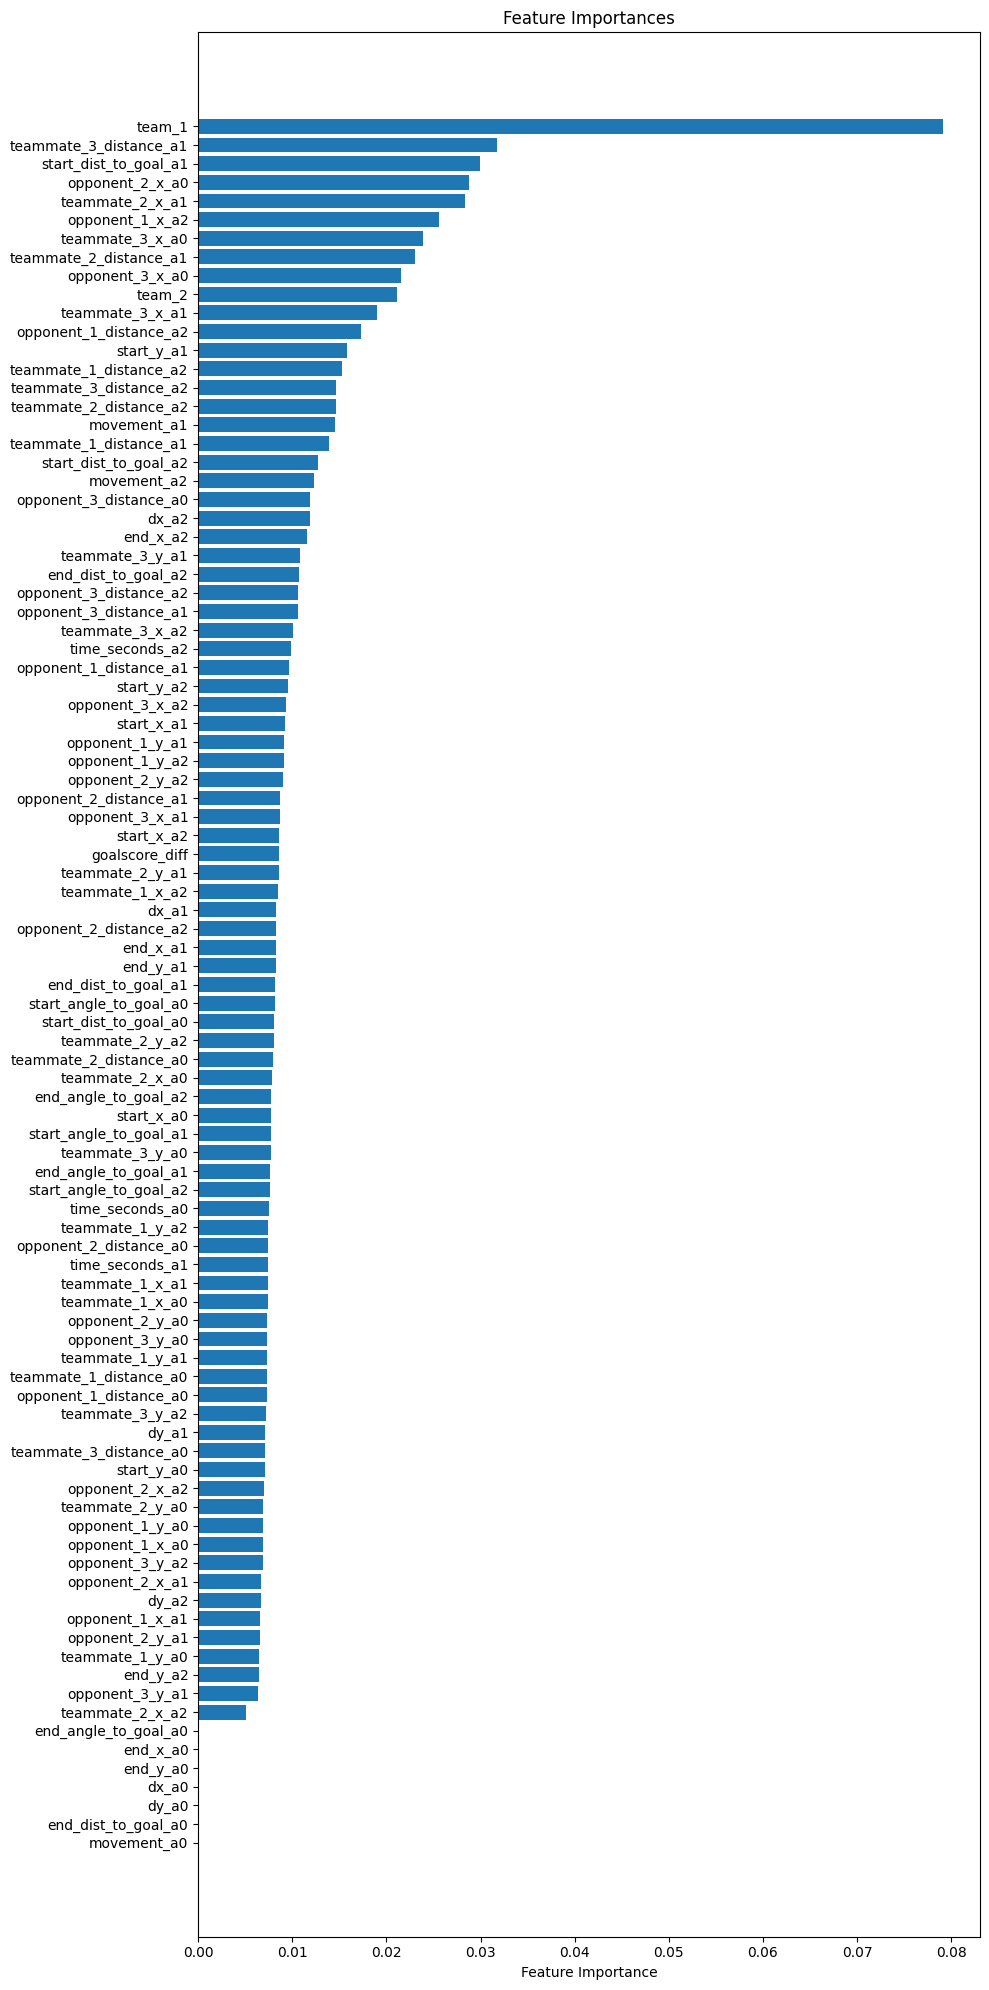

In [34]:
features = [col for _, cols in model.features.items() for col in cols]
importances = model.model.feature_importances_

# 컬럼 수에 따라 가변적인 시각화 크기 설정
num_features = len(features)
plt.figure(figsize=(max(10, num_features * 0.1), 20))  # 특징 수에 따라 증가


indices = np.argsort(importances) 
plt.barh(range(num_features), importances[indices], align='center')
plt.yticks(range(num_features), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importances')

plt.tight_layout()
plt.show()

In [35]:
game_id = 3895302

df_actions = add_names(train_db.actions(game_id)).reset_index()
df_actions.head()

,game_id,action_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,...,possession_team_id,play_pattern_name,under_pressure,extra,visible_area_360,in_visible_area_360,freeze_frame_360,type_name,result_name,bodypart_name
0,3895302,0,221b0c8d-6386-4ae8-bb4a-a1dc98742312,1,3.417,176,34870,52.0625,33.660,53.8125,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 12299, 'name': '...",None,0,None,pass,success,foot_right
1,3895302,1,77809242-1460-4395-8779-94a0cfc275b1,1,3.870,176,12299,53.8125,34.340,53.8125,...,176.0,From Kick Off,0,"{'carry': {'end_location': [59.0, 40.6]}}",None,0,None,dribble,success,foot
2,3895302,2,ff56e821-21e9-4cef-ba2a-7eb5eb3769c6,1,4.732,176,12299,53.8125,34.085,74.7250,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 31100, 'name': '...","[[90.44126933110154, 68.0], [67.695055809645, ...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right
3,3895302,3,cf9088bc-7e59-4d57-8ac5-31658da858bb,1,6.728,176,31100,74.7250,36.295,74.7250,...,176.0,From Kick Off,0,"{'carry': {'end_location': [35.1, 43.7]}}","[[94.70003623525969, 68.0], [70.82236198763701...",1,"[{'teammate': True, 'actor': True, 'keeper': F...",dribble,success,foot
4,3895302,4,4464cb75-f45f-4508-8444-2560d1625d06,1,7.622,176,31100,74.7250,36.720,76.3875,...,176.0,From Kick Off,0,"{'pass': {'recipient': {'id': 51769, 'name': '...","[[96.23592025888192, 68.0], [71.95638033011264...",1,"[{'teammate': True, 'actor': False, 'keeper': ...",pass,success,foot_right


### Visualization

Skip action due to missing freeze frame


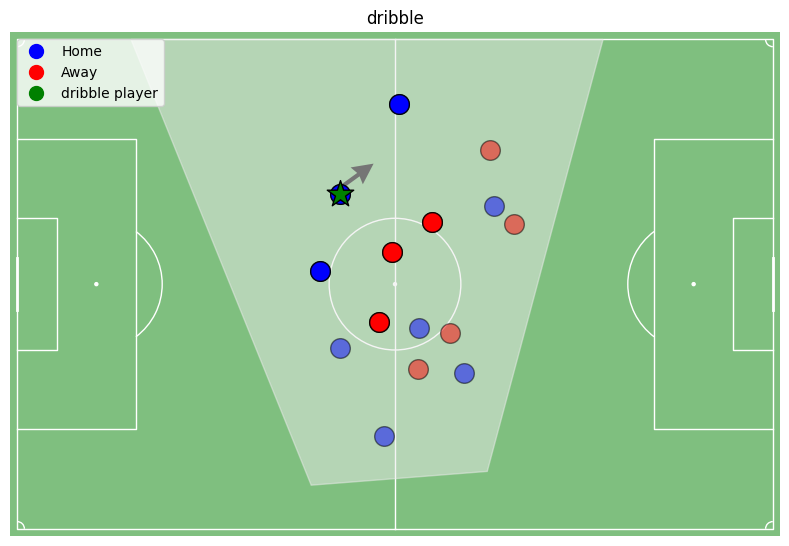

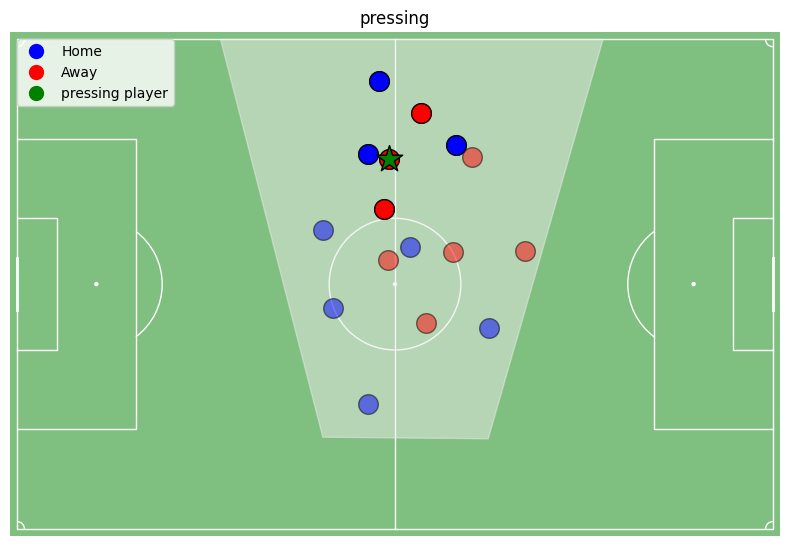

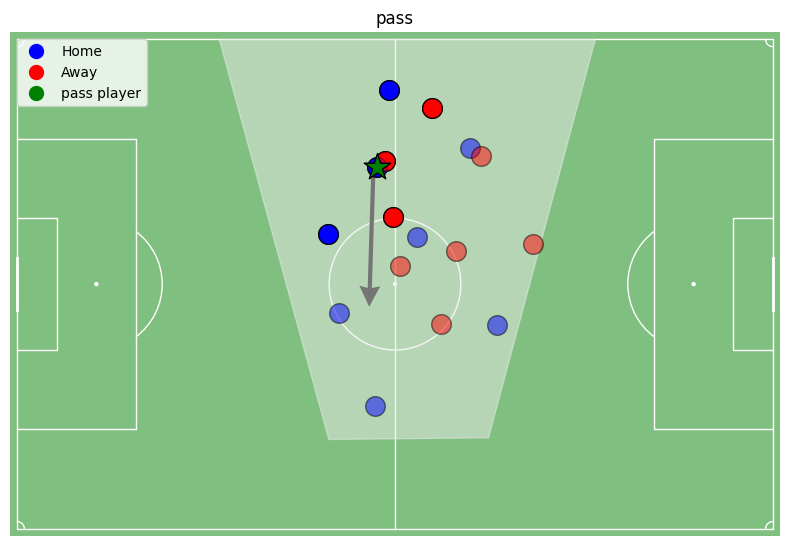

In [36]:
pressure_idx = df_actions[df_actions["type_name"] == "pressing"].index[5]
home_team_id, away_team_id = train_db.get_home_away_team_id(game_id = 3895302)
for idx in range(pressure_idx-2, pressure_idx+2):
    if df_actions.loc[idx]["freeze_frame_360"] is None:
        print("Skip action due to missing freeze frame")
        continue
    plot_action(df_actions.loc[idx], home_team_id=home_team_id)